<a href="https://colab.research.google.com/github/ValentinCord/HandsOnAI_2/blob/main/NLP_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# basics 
import os
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from google.colab import drive

# nltk 
from collections import defaultdict
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('french'))

# plot 
import matplotlib.pyplot as plt 
import seaborn as sns 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Lecture et analyse pandas

In [75]:
train_path = '/content/drive/MyDrive/HandOnAI_2_NLP/fake_train.csv'
test_path = '/content/drive/MyDrive/HandOnAI_2_NLP/fake_test.csv'

In [76]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [77]:
df_train.head()

,Unnamed: 0,data,label,target_name
0,0,Au 22e jour consécutif de la grève reconductib...,0,News
1,1,"Depuis plusieurs mois, les initiatives des che...",0,News
2,2,Google vient d'introduire une mise à jour de...,0,News
3,3,Portrait. Chacun s’empresse autour d’elle tan...,0,News
4,4,« Il n’y a pas de risque de pénurie » de carbu...,0,News


In [78]:
df_train['label'].value_counts()

0    816
1    642
Name: label, dtype: int64

In [79]:
df_train['target_name'].value_counts()

News         816
Fake News    642
Name: target_name, dtype: int64

In [80]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

In [81]:
df_train['len_data'] = df_train['data'].apply(lambda x: len(x))
df_test['len_data'] = df_test['data'].apply(lambda x: len(x))

In [82]:
df_train['log_len_data'] = np.log(df_train['len_data'])
df_test['log_len_data'] = np.log(df_test['len_data'])

In [83]:
df_train.head()

,data,label,len_data,log_len_data
0,Au 22e jour consécutif de la grève reconductib...,0,631,6.447306
1,"Depuis plusieurs mois, les initiatives des che...",0,2610,7.867106
2,Google vient d'introduire une mise à jour de...,0,2231,7.710205
3,Portrait. Chacun s’empresse autour d’elle tan...,0,2990,8.003029
4,« Il n’y a pas de risque de pénurie » de carbu...,0,1296,7.167038


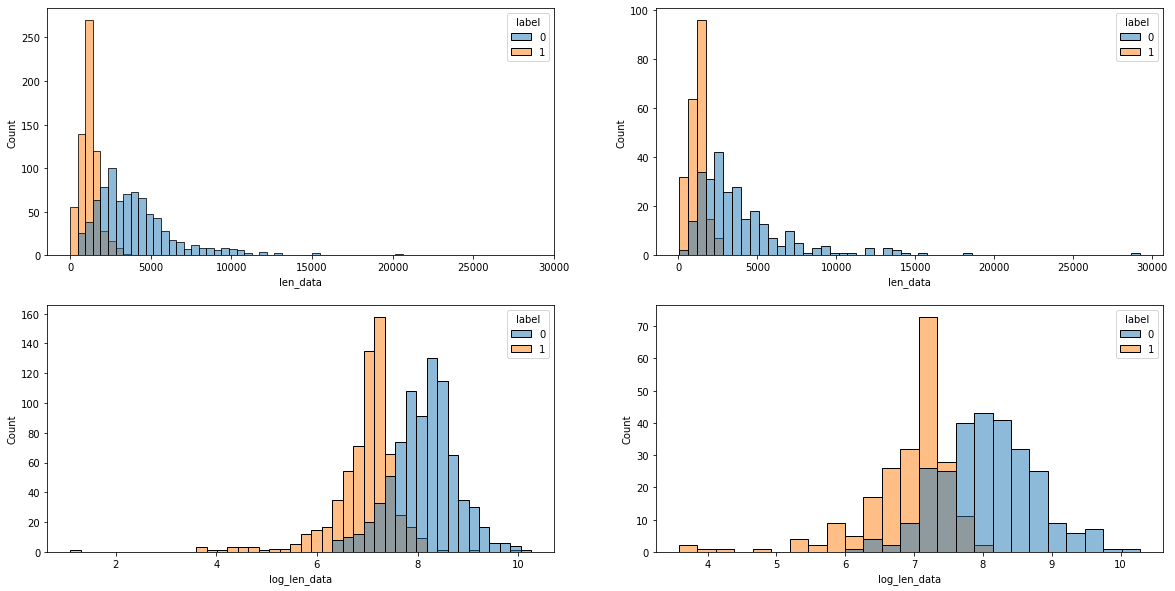

In [84]:
fig,(ax1,ax2)=plt.subplots(2,2,figsize=(20,10))
sns.histplot(data = df_train, x = 'len_data', hue = 'label', ax=ax1[0])
sns.histplot(data = df_test, x = 'len_data', hue = 'label', ax = ax1[1])

sns.histplot(data = df_train, x = 'log_len_data', hue = 'label', ax = ax2[0])
sns.histplot(data = df_test, x = 'log_len_data', hue = 'label', ax = ax2[1])


In [85]:
import spacy 
!python3 -m spacy download fr_core_news_md
from spacy.lang.fr.examples import sentences 

nlp = spacy.load("fr_core_news_md")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45.8 MB 1.7 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.

Text(0.5, 0.98, 'Average word length in each tweet')

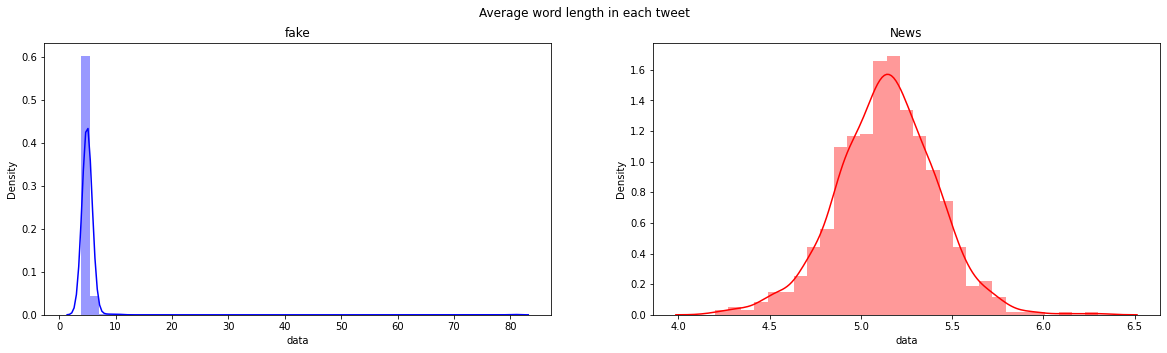

In [86]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
word=df_train[df_train['label']==1]['data'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('fake')
word=df_train[df_train['label']==0]['data'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('News')
fig.suptitle('Average word length in each tweet')

In [87]:
def create_corpus(df, label):
    corpus=[]
    
    for x in df[df['label']==label]['data'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

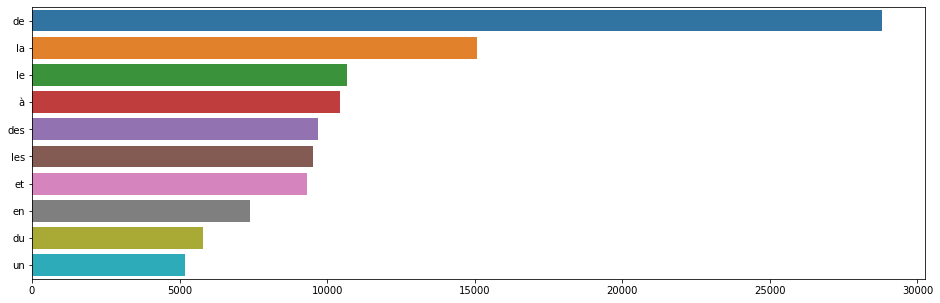

In [88]:
corpus=create_corpus(df_train, 0)
dic=defaultdict(int)
for word in corpus:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:10]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)

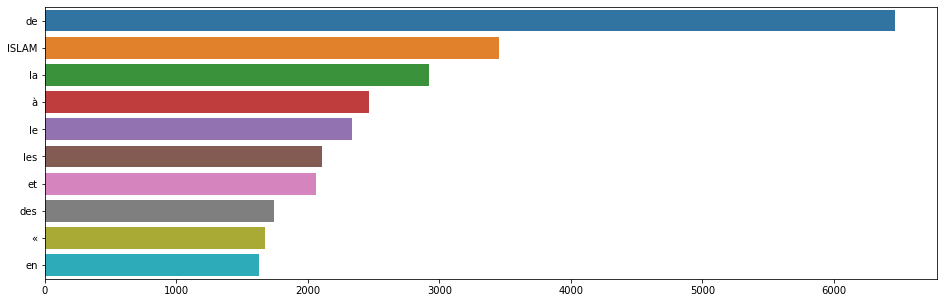

In [89]:
corpus=create_corpus(df_train, 1)
dic=defaultdict(int)
for word in corpus:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:10]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)

In [101]:
import re

REPLACE_BY_SPACE_RE = re.compile('[/(){}\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-zÀ-ÿ #+_]')
STOPWORDS = set(stopwords.words('french'))

new_stopwords = {"a", "comme", "cette", "dun", "dune", "plus", 'cest', "aussi", "deux", 'fait', "depuis", "faire", "tout", "si", "où"}
STOPWORDS = STOPWORDS | new_stopwords

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [102]:
df_train['data'] = df_train["data"].apply(lambda x : clean_text(x))
df_test['data'] = df_test["data"].apply(lambda x : clean_text(x))

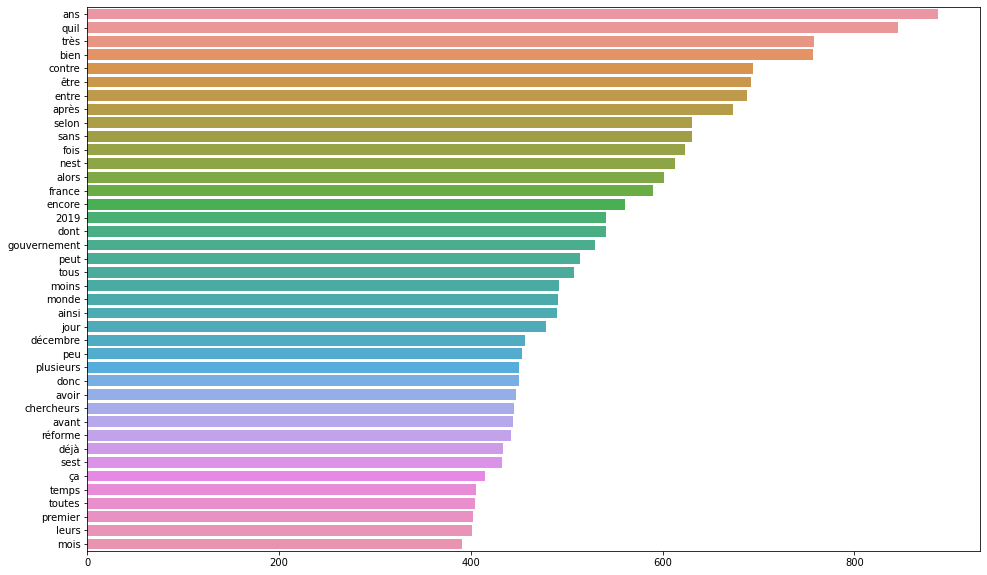

In [105]:
corpus=create_corpus(df_train, 0)
dic=defaultdict(int)
for word in corpus:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

plt.figure(figsize=(16,10))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)

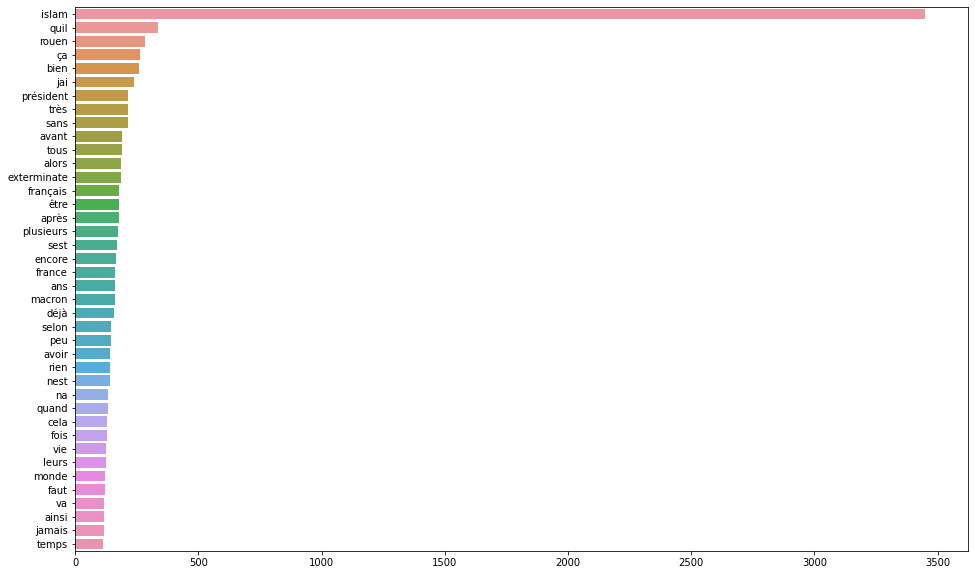

In [107]:
corpus=create_corpus(df_train, 1)
dic=defaultdict(int)
for word in corpus:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]

plt.figure(figsize=(16,10))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    x.append(word)
    y.append(count)

sns.barplot(x=y,y=x)

In [118]:
for idx, di in enumerate(df_train['data']): 
  text = di.split()
  if "islam" in text: 
    print(idx)

153
520
1136


In [123]:
df_train.iloc[1136].data

'juin 2019 sapeurspompiers toute france déposé préavis grève dénonçant leurs conditions travail réunis paris mardi 15 octobre 2019 manifestation denvergure leurs revendications sécurité retraite assurée revalorisation prime feu moyens parti république début daprèsmidi cortège devait disperser nation vers 18 heures dautres manifestations déjà lieu derniers mois notamment versailles yvelines pardon faisait linformation faut cela cesse immédiatement islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam islam isl